In [1]:
import glob
import json
import os
import pickle
import random
import time

import cv2
import detectron2
import numpy as np
import torch, torchvision

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.data import samplers
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from torch.utils.data import Dataset, DataLoader

ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(
    os.path.join(local_paths["general_dection_path"],
                 "detectron2_classes"
                )
)
sys.path.append(local_paths['overhead_functions_path'])

from DetectionDatasetMapper import DetectionDatasetMapper
import koger_general_functions as kgf

In [2]:
detectron2.__version__

'0.2.1'

In [3]:
# class PredictDataset(Dataset):
    
#     def __init__(self, image_files, image_format):
#         self.image_files = image_files
#         self.img_format = image_format
        
#     def __len__(self):
#         return len(self.image_files)
    
#     def __getitem__(self, idx):
#         image = utils.read_image(self.image_files[idx], 
#                                  format=self.img_format)
#         image_raw = cv2.imread(self.image_files[idx])
#         image = torch.as_tensor(image_raw.astype("float32").transpose(2, 0, 1)).contiguous()
#         image_dict = {"image": image}
#         return image_dict

In [4]:
# from detectron2.data.datasets import register_coco_instances

# # CAN BE ANY BABOON .json ANNOTATION FILE

# register_coco_instances("train", {}, 
#                         "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/train.json", 
#                         "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/images")

# train_metadata = MetadataCatalog.get("train")

In [3]:
models_folder = os.path.join(os.path.dirname(os.getcwd()), 
                             'model-training', 'output')
model_name = "full-resolution-model_maxiter-133600_lr-0.0019_detectPerIm-200_minsize-0_batchsize-8"
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

cfg = get_cfg()

with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(models_folder, model_name, 
                           "best-model-config-iter-*.pth"))
)
cfg.MODEL.WEIGHTS = weights_path[-1]

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [4]:
def load_inference_instances(image_files):
    """ Use all given files to make Detectron2 format list of dicts."""
    dataset_dicts = []
    for image_file in image_files:
        record = {"file_name": image_file}
        dataset_dicts.append(record)
    return dataset_dicts

def register_inference_instances(name, image_files):
    """ Register dataset to use for inference. 
    
    Only image file paths are used.
    
    Args:
        name: name of Dataset
        image_files: list of image_files
    """
    DatasetCatalog.register(name, lambda: load_inference_instances(image_files))


In [6]:
# name of observation to process
observation_name = "observation088"

# ---------------------------------------

frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)
frame_files = kgf.get_observation_frame_files(frame_folders_root)

print(f"Processing {len(frame_files)} frames.")

save_root = os.path.join(local_paths['processed_folder'], observation_name)
os.makedirs(save_root, exist_ok=True)
print(f"Saving at: {save_root}")

Processing 90732 frames.
Saving at: /home/golden/kenya_drones/processing/kenya-tracking/processed-videos/raw-footage/observation088


In [8]:
batch_size=2
register_inference_instances("inference", frame_files)
mapper = DetectionDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "inference", mapper=mapper)

AssertionError: Dataset 'inference' is already registered!

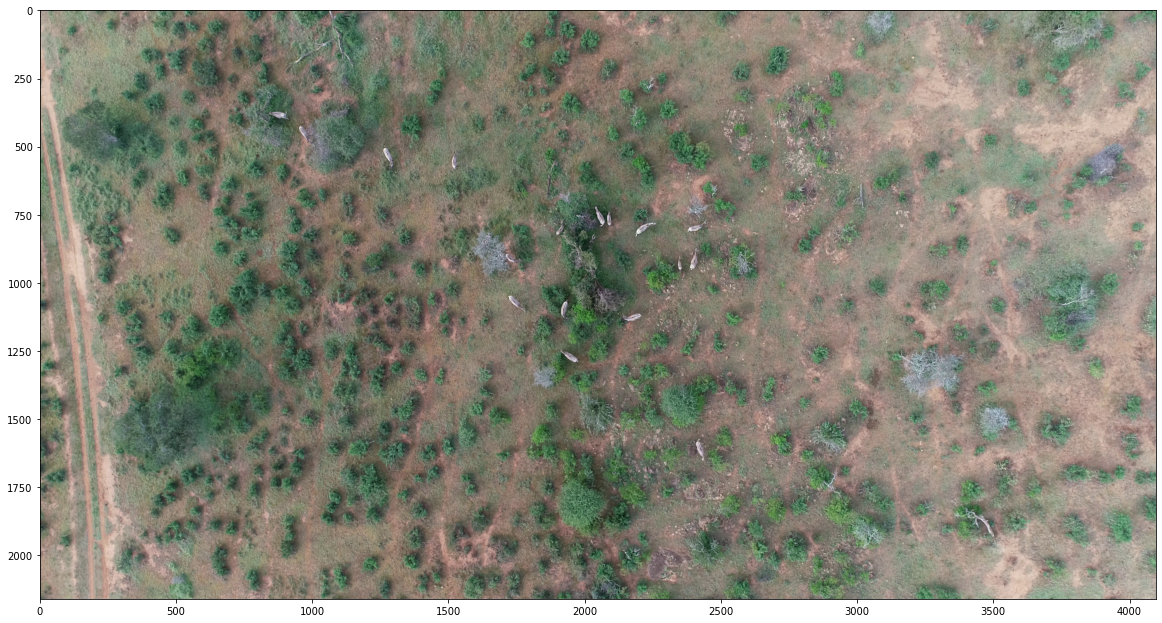

In [9]:
import matplotlib.pyplot as plt
for batch in loader:
    image = batch[0]['image'].numpy()
    image = np.transpose(image, [1, 2, 0])
    plt.figure(figsize=(20, 20))
    plt.imshow(image[..., ::-1].astype(np.uint8))
    break

In [10]:
model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

In [18]:
import pickle
import os

max_batches = None

all_detections = []

t = time.time()
with torch.no_grad():
    for batch_num, image_batch in enumerate(loader):
        if max_batches:
            if batch_num >= max_batches:
                break
            
        if batch_num % 1000 == 0:
            cur_time = time.time()
            print(f"{batch_num} images processed. fps: {batch_num/(cur_time-t)}")
        detections = model(image_batch)



        detection_dict = detections[0]['instances'].get_fields()
        detection_dict['pred_boxes'] = detection_dict['pred_boxes'].tensor.cpu().numpy()
        detection_dict['scores'] = detection_dict['scores'].cpu().numpy()
        detection_dict['pred_classes'] = detection_dict['pred_classes'].cpu().numpy()
        detection_dict['image_name'] = os.path.basename(image_batch[0]['file_name'])
        all_detections.append(detection_dict)


np_detections_file = os.path.join(save_root, '{}_detections.npy'.format(observation_name))
np.save(np_detections_file, all_detections)
            
print(time.time() - t)

In [12]:
os.path.basename(image_batch[0]['file_name'])

'APR08_2018_C_DJI_0012_09534.jpg'

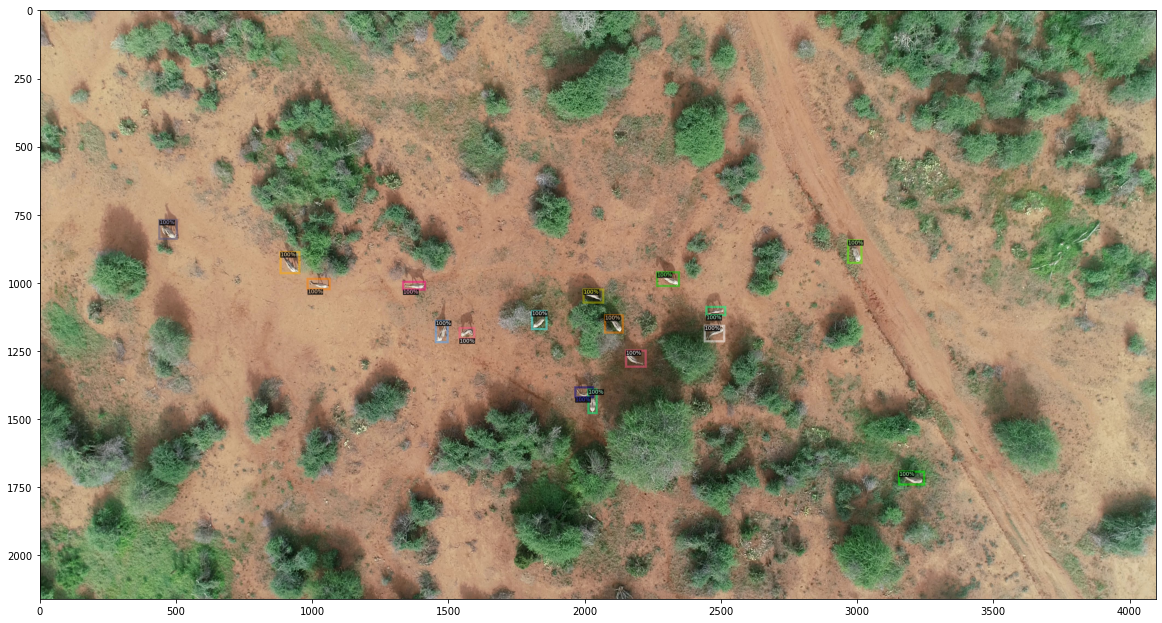

In [17]:
image = image_batch[0]['image'].numpy()
image = np.transpose(image, [1, 2, 0])

v = Visualizer(image[...,::-1],
               metadata=None,
               scale=1.0,
)
v = v.draw_instance_predictions(detections[0]['instances'])
plt.figure(figsize=(20,20))
plt.imshow(v.get_image())